In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from datetime import datetime

# Base de dados das ligações

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/lucasgmalheiros/projeto-simulacao-VCBC/main/calls.csv")
# Conversão do time stamp da data
df["date"] = pd.to_datetime(df.date, format="%d/%m/%Y")
df["call_started"] = pd.to_datetime(df.call_started, format="%I:%M:%S %p")
df.head()

call_id       date  daily_caller        call_started call_answered  \
0        1 2021-01-01             1 1900-01-01 08:00:00    8:00:00 AM   
1        2 2021-01-01             2 1900-01-01 08:02:42    8:02:42 AM   
2        3 2021-01-01             3 1900-01-01 08:08:24    8:08:24 AM   
3        4 2021-01-01             4 1900-01-01 08:09:37    8:09:37 AM   
4        5 2021-01-01             5 1900-01-01 08:11:10    8:11:10 AM   

   call_ended  wait_length  service_length  meets_standard  call_type  
0  8:14:22 AM            0             863            True          1  
1  8:07:31 AM            0             289            True          0  
2  8:10:13 AM            0             108            True          1  
3  8:13:45 AM            0             247            True          1  
4  8:15:28 AM            0             258            True          1

O gerente deseja que 90% das chamadas sejam atendidas em até um minuto

In [3]:
# Chamadas que aguardam mais de um minuto (60 segundos)
df.loc[df["wait_length"] > 60].head()

call_id       date  daily_caller        call_started call_answered  \
11        12 2021-01-01            12 1900-01-01 08:28:25    8:29:37 AM   
207      208 2021-01-04            62 1900-01-01 13:10:31    1:11:38 PM   
209      210 2021-01-04            64 1900-01-01 13:13:08    1:15:37 PM   
240      241 2021-01-04            95 1900-01-01 15:24:55    3:26:03 PM   
241      242 2021-01-04            96 1900-01-01 15:25:33    3:28:01 PM   

     call_ended  wait_length  service_length  meets_standard  call_type  
11   8:33:30 AM           72             232           False          1  
207  1:15:37 PM           67             238           False          1  
209  1:27:35 PM          149             718           False          1  
240  3:28:42 PM           68             159           False          2  
241  3:29:01 PM          148              60           False          1

## Análise anual

In [4]:
# Número de chamadas analisadas
n = len(df)  # 51708

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = df.loc[df["wait_length"] > 60]
qtd_falhas = len(falhas)  # 4227

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações demoraram mais de 60 segundos para serem atendidas")

No ano de 2021, em média, 8.17% das ligações demoraram mais de 60 segundos para serem atendidas


### Distribuição de ligações por dia do ano

In [5]:
# Quantidade de dias comerciais registrados
len(df["date"].unique())

261

In [6]:
# Agrupando ligações por dia
ligacoes = df.groupby(["date"])["daily_caller"].max()
ligacoes.head()

date
2021-01-01    146
2021-01-04    135
2021-01-05    143
2021-01-06    150
2021-01-07    133
Name: daily_caller, dtype: int64

In [7]:
# Mostra a tendência de ligações por dia ao longo do ano
fig = px.line(ligacoes)
fig.show()

Há uma tendência linear de crescimento do número de ligações recebidas por dia ao longo do ano

### Estatística descritiva do tempo de serviço e de espera

In [8]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",df["wait_length"].describe(),
      "\n","-"*100)
# Ligações recebidas
print("\n","Descrição das ligações:",ligacoes.describe(), "\n","-"*100)
# Tempo de serviço
print("\n Descrição do Tempo de Serviço: \n",df["service_length"].describe(),
      "\n","-"*100)

Descrição do Tempo de Espera: 
 count    51708.000000
mean        17.034927
std         64.060769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        983.000000
Name: wait_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------

 Descrição das ligações: count    261.000000
mean     198.708812
std       43.165953
min      115.000000
25%      162.000000
50%      193.000000
75%      236.000000
max      297.000000
Name: daily_caller, dtype: float64 
 ----------------------------------------------------------------------------------------------------

 Descrição do Tempo de Serviço: 
 count    51708.000000
mean       299.102595
std        299.865751
min          0.000000
25%         86.000000
50%        208.000000
75%        414.000000
max       3110.000000
Name: service_length, dtype: float64 
 ---------------------------------------------------------------------------------

In [9]:
# Boxplot tempo de espera
fig = px.box(df, y="wait_length")
fig.show()

Há muitos outliers pois mais de 75% dos valores de tempo de espera são nulos, é melhor não retirá-los

In [10]:
# Boxplot tempo de serviço
fig = px.box(df, y="service_length")
fig.show()

Há também alguns outliers na análise do tempo de serviço que não julgamos necessário retirar, pois é interessante modelar essa variável aleatória com uma distribuição que levem em consideração a presença de valores extremos

In [11]:
# Comportamento do tempo médio de serviço ao longo do ano
t_servico = df.groupby(["date"])["service_length"].mean()
t_servico.head()

date
2021-01-01    303.157534
2021-01-04    305.325926
2021-01-05    254.049296
2021-01-06    250.533333
2021-01-07    343.090226
Name: service_length, dtype: float64

In [12]:
# Gráfico de linha do tempo de serviço médio ao longo do ano
fig = px.line(t_servico)
fig.show()

O tempo de serviço é aparentemente constante ao longo do ano, variando entre 4 e 6 minutos por ligação

In [13]:
# Save wait times
# np.savetxt(r".\times\wait_times.txt", df["wait_length"].values, fmt='%d')
# Save service times
# np.savetxt(r".\times\service_times.txt", df["service_length"].values, fmt='%d')

### Fit dos tempos de serviço

In [14]:
fig = px.histogram(df, x="service_length")
fig.show()

O histograma com os valores de tempos de serviço apresenta comportamento similar ao de uma distribuição exponencial

Fitting 10 distributions: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
expon        3.228528e-08  2183.934331 -1.453078e+06     inf      0.002908   
chi2         3.315558e-08  2184.919713 -1.451691e+06     inf      0.006581   
gamma        3.361879e-08  2185.604830 -1.450974e+06     inf      0.006852   
exponpow     1.258152e-06  2611.983213 -1.263671e+06     inf      0.049770   
cauchy       1.139810e-05  2040.311055 -1.149728e+06     inf      0.197659   

              ks_pvalue  
expon      7.733781e-01  
chi2       2.258019e-02  
gamma      1.549740e-02  
exponpow  9.426228e-112  
cauchy     0.000000e+00

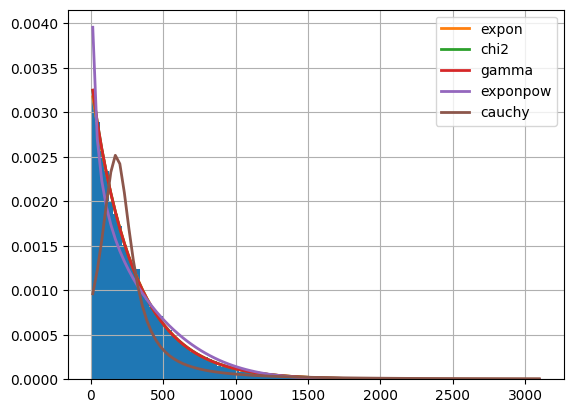

In [15]:
tempos_servico = df["service_length"].values
f = Fitter(tempos_servico, distributions=get_common_distributions())
f.fit()
f.summary()

A distribuição exponencial é a candidada mais adequada para modelar o tempo de serviço

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
expon     3.228528e-08  2183.934331 -1.453078e+06     inf      0.002908   

       ks_pvalue  
expon   0.773378

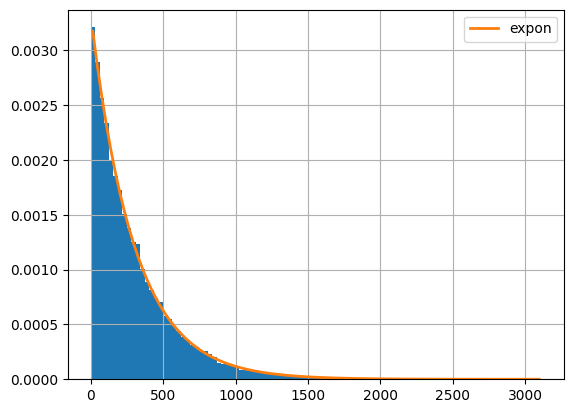

In [16]:
f = Fitter(tempos_servico, distributions="expon")
f.fit()
f.summary()

In [17]:
# Melhor fit para tempos de serviço é exponencial
f.get_best(method = 'sumsquare_error')

{'expon': {'loc': 0.0, 'scale': 299.1025953430804}}

In [18]:
# Exponencial de média 299,1
f.fitted_param["expon"]

(0.0, 299.1025953430804)

O tempo de serviço pode ser modelado por uma exponencial de média $299.10$

#### Tempos de serviço por tipo

In [19]:
# Tipos de serviçob
df["call_type"].unique()

array([1, 0, 2], dtype=int64)

### Análise das chegadas

Avaliaremos o tempo de chegada a partir da diferença entre a chegada das chamadas em um dia

In [20]:
df["arrival_time_diff"] = df["call_started"].diff().dt.total_seconds()
df.head()

call_id       date  daily_caller        call_started call_answered  \
0        1 2021-01-01             1 1900-01-01 08:00:00    8:00:00 AM   
1        2 2021-01-01             2 1900-01-01 08:02:42    8:02:42 AM   
2        3 2021-01-01             3 1900-01-01 08:08:24    8:08:24 AM   
3        4 2021-01-01             4 1900-01-01 08:09:37    8:09:37 AM   
4        5 2021-01-01             5 1900-01-01 08:11:10    8:11:10 AM   

   call_ended  wait_length  service_length  meets_standard  call_type  \
0  8:14:22 AM            0             863            True          1   
1  8:07:31 AM            0             289            True          0   
2  8:10:13 AM            0             108            True          1   
3  8:13:45 AM            0             247            True          1   
4  8:15:28 AM            0             258            True          1   

   arrival_time_diff  
0                NaN  
1              162.0  
2              342.0  
3               73.0  
4               93.0

In [21]:
# Substitui os valores inadequados por 0
df.loc[df["arrival_time_diff"] < 0, "arrival_time_diff"] = 0
df = df.fillna(0)
df.head()

call_id       date  daily_caller        call_started call_answered  \
0        1 2021-01-01             1 1900-01-01 08:00:00    8:00:00 AM   
1        2 2021-01-01             2 1900-01-01 08:02:42    8:02:42 AM   
2        3 2021-01-01             3 1900-01-01 08:08:24    8:08:24 AM   
3        4 2021-01-01             4 1900-01-01 08:09:37    8:09:37 AM   
4        5 2021-01-01             5 1900-01-01 08:11:10    8:11:10 AM   

   call_ended  wait_length  service_length  meets_standard  call_type  \
0  8:14:22 AM            0             863            True          1   
1  8:07:31 AM            0             289            True          0   
2  8:10:13 AM            0             108            True          1   
3  8:13:45 AM            0             247            True          1   
4  8:15:28 AM            0             258            True          1   

   arrival_time_diff  
0                0.0  
1              162.0  
2              342.0  
3               73.0  
4               93.0

In [22]:
# Agrupando time_diff por dia e obtendo a média
chegadas = df.groupby(["date"])["arrival_time_diff"].mean()
chegadas.head()

date
2021-01-01    244.273973
2021-01-04    264.740741
2021-01-05    251.098592
2021-01-06    238.033333
2021-01-07    263.360902
Name: arrival_time_diff, dtype: float64

In [23]:
# Mostra a tendência de tempo de chegada de ligações por dia ao longo do ano
fig = px.line(chegadas)
fig.show()

Há uma tendência linear de queda do tempo médio entre as chegadas ao longo do ano, isso está de acordo com a constatação de que o número de chamadas recebidas aumenta linearmente ao longo do ano

In [24]:
df["arrival_time_diff"].describe()

count    51708.000000
mean       179.667653
std        188.006518
min          0.000000
25%         49.000000
50%        121.000000
75%        246.000000
max       2718.000000
Name: arrival_time_diff, dtype: float64

Fitting 10 distributions: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


sumsquare_error          aic           bic  kl_div  ks_statistic  \
chi2         5.346430e-08  2563.890652 -1.426985e+06     inf      0.013716   
expon        1.819042e-07  2555.014934 -1.363681e+06     inf      0.013135   
gamma        3.276612e-06  2773.384355 -1.214178e+06     inf      0.086325   
exponpow     4.778697e-06  3274.372378 -1.194666e+06     inf      0.113025   
cauchy       2.201689e-05  2100.782890 -1.115685e+06     inf      0.201092   

             ks_pvalue  
chi2      7.027466e-09  
expon     3.530446e-08  
gamma     0.000000e+00  
exponpow  0.000000e+00  
cauchy    0.000000e+00

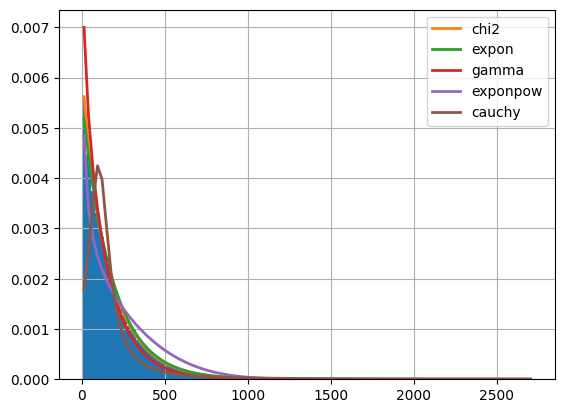

In [25]:
arrival_times = df["arrival_time_diff"].values
f = Fitter(arrival_times, distributions=get_common_distributions())
f.fit()
f.summary()

In [26]:
# Melhor fit para tempos de serviço é exponencial
f.get_best(method = 'sumsquare_error')

{'chi2': {'df': 1.9018976509906962,
  'loc': -7.88694411448581e-08,
  'scale': 90.93947322161421}}

O fit para o ano todo não modela tão bem o problema, visto que os tempos de chegada das chamadas variam ao longo do ano

### Análise por call types

#### Call type 0

In [27]:
call_type_0 = df.loc[df["call_type"] == 0]
call_type_0.head()


call_id       date  daily_caller        call_started call_answered  \
1         2 2021-01-01             2 1900-01-01 08:02:42    8:02:42 AM   
17       18 2021-01-01            18 1900-01-01 08:47:27    8:47:27 AM   
18       19 2021-01-01            19 1900-01-01 08:53:59    8:53:59 AM   
22       23 2021-01-01            23 1900-01-01 09:12:34    9:12:34 AM   
24       25 2021-01-01            25 1900-01-01 09:23:00    9:23:00 AM   

    call_ended  wait_length  service_length  meets_standard  call_type  \
1   8:07:31 AM            0             289            True          0   
17  8:47:39 AM            0              13            True          0   
18  9:16:07 AM            0            1328            True          0   
22  9:14:05 AM            0              92            True          0   
24  9:31:16 AM            0             496            True          0   

    arrival_time_diff  
1               162.0  
17               82.0  
18              392.0  
22              196.0  
24              495.0

In [28]:
# Número de chamadas analisadas
n = len(call_type_0)
print("Ligações do tipo 0 atendidas:", n)

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = call_type_0.loc[call_type_0["wait_length"] > 60]
qtd_falhas = len(falhas) 
print("Ligações que demoraram mais de 60 segundos para atendimento:", qtd_falhas)

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações do tipo 0 demoraram mais de 60 segundos para serem atendidas")

Ligações do tipo 0 atendidas: 12830
Ligações que demoraram mais de 60 segundos para atendimento: 1069
No ano de 2021, em média, 8.33% das ligações do tipo 0 demoraram mais de 60 segundos para serem atendidas


In [29]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",call_type_0["wait_length"].describe(),"\n","-"*100)
# Tempo de serviço
print("\n Descrição do Tempo de Serviço: \n",call_type_0["service_length"].describe(),"\n","-"*100)

Descrição do Tempo de Espera: 
 count    12830.000000
mean        17.580670
std         65.810723
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        983.000000
Name: wait_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------

 Descrição do Tempo de Serviço: 
 count    12830.000000
mean       298.403663
std        297.365515
min          0.000000
25%         87.000000
50%        209.000000
75%        413.000000
max       2714.000000
Name: service_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------


#### Call type 1

In [30]:
call_type_1 = df.loc[df["call_type"] == 1]
call_type_1.head()

call_id       date  daily_caller        call_started call_answered  \
0        1 2021-01-01             1 1900-01-01 08:00:00    8:00:00 AM   
2        3 2021-01-01             3 1900-01-01 08:08:24    8:08:24 AM   
3        4 2021-01-01             4 1900-01-01 08:09:37    8:09:37 AM   
4        5 2021-01-01             5 1900-01-01 08:11:10    8:11:10 AM   
5        6 2021-01-01             6 1900-01-01 08:22:33    8:22:33 AM   

   call_ended  wait_length  service_length  meets_standard  call_type  \
0  8:14:22 AM            0             863            True          1   
2  8:10:13 AM            0             108            True          1   
3  8:13:45 AM            0             247            True          1   
4  8:15:28 AM            0             258            True          1   
5  8:28:13 AM            0             340            True          1   

   arrival_time_diff  
0                0.0  
2              342.0  
3               73.0  
4               93.0  
5              683.0

In [31]:
# Número de chamadas analisadas
n = len(call_type_1)
print("Ligações do tipo 1 atendidas:", n)

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = call_type_1.loc[call_type_1["wait_length"] > 60]
qtd_falhas = len(falhas)
print("Ligações que demoraram mais de 60 segundos para atendimento:", qtd_falhas)

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações do tipo 1 demoraram mais de 60 segundos para serem atendidas")

Ligações do tipo 1 atendidas: 25792
Ligações que demoraram mais de 60 segundos para atendimento: 2100
No ano de 2021, em média, 8.14% das ligações do tipo 1 demoraram mais de 60 segundos para serem atendidas


In [32]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",call_type_1["wait_length"].describe(),"\n","-"*100)
# Tempo de serviço
print("\n Descrição do Tempo de Serviço: \n",call_type_1["service_length"].describe(),"\n","-"*100)

Descrição do Tempo de Espera: 
 count    25792.000000
mean        16.857979
std         63.444580
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        902.000000
Name: wait_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------

 Descrição do Tempo de Serviço: 
 count    25792.000000
mean       300.464757
std        302.816407
min          0.000000
25%         85.000000
50%        208.000000
75%        416.000000
max       3110.000000
Name: service_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------


#### Call type 2

In [33]:
call_type_2 = df.loc[df["call_type"] == 2]
call_type_2.head()

call_id       date  daily_caller        call_started call_answered  \
6         7 2021-01-01             7 1900-01-01 08:23:18    8:23:18 AM   
8         9 2021-01-01             9 1900-01-01 08:25:08    8:25:08 AM   
9        10 2021-01-01            10 1900-01-01 08:27:58    8:27:58 AM   
13       14 2021-01-01            14 1900-01-01 08:36:13    8:36:13 AM   
14       15 2021-01-01            15 1900-01-01 08:43:28    8:43:28 AM   

    call_ended  wait_length  service_length  meets_standard  call_type  \
6   8:34:14 AM            0             656            True          2   
8   8:25:32 AM            0              23            True          2   
9   8:37:40 AM            0             582            True          2   
13  8:37:03 AM            0              50            True          2   
14  8:55:37 AM            0             729            True          2   

    arrival_time_diff  
6                45.0  
8                71.0  
9               170.0  
13                9.0  
14              435.0

In [34]:
# Número de chamadas analisadas
n = len(call_type_2)
print("Ligações do tipo 2 atendidas:", n)

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = call_type_2.loc[call_type_2["wait_length"] > 60]
qtd_falhas = len(falhas)
print("Ligações que demoraram mais de 60 segundos para atendimento:", qtd_falhas)

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações do tipo 2 demoraram mais de 60 segundos para serem atendidas")

Ligações do tipo 2 atendidas: 13086
Ligações que demoraram mais de 60 segundos para atendimento: 1058
No ano de 2021, em média, 8.08% das ligações do tipo 2 demoraram mais de 60 segundos para serem atendidas


In [35]:
# Tempo de espera
print("Descrição do Tempo de Espera: \n",call_type_2["wait_length"].describe(),
      "\n","-"*100)
# Tempo de serviço
print("\n Descrição do Tempo de Serviço: \n",
      call_type_2["service_length"].describe(),"\n","-"*100)

Descrição do Tempo de Espera: 
 count    13086.000000
mean        16.848617
std         63.529974
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        904.000000
Name: wait_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------

 Descrição do Tempo de Serviço: 
 count    13086.000000
mean       297.103087
std        296.452317
min          0.000000
25%         85.000000
50%        206.000000
75%        410.750000
max       2551.000000
Name: service_length, dtype: float64 
 ----------------------------------------------------------------------------------------------------


Parece que não há diferenças significativas entre os tipos de ligações ao analisarmos tempo de espera, tempo de atendimento e percentual de falhas de cada um deles. Pode ser interessante fazer um teste estatístico que comprove que são iguais (algum teste de média como o teste t)

## Análise mensal

Precisamos agora fazer análises dos tempos de chegada mês a mês para achar a distribuição com melhor fit e fazer schedule no arena

### Janeiro

In [36]:
df.loc[df['date'].dt.month==1]

call_id       date  daily_caller        call_started call_answered  \
0           1 2021-01-01             1 1900-01-01 08:00:00    8:00:00 AM   
1           2 2021-01-01             2 1900-01-01 08:02:42    8:02:42 AM   
2           3 2021-01-01             3 1900-01-01 08:08:24    8:08:24 AM   
3           4 2021-01-01             4 1900-01-01 08:09:37    8:09:37 AM   
4           5 2021-01-01             5 1900-01-01 08:11:10    8:11:10 AM   
...       ...        ...           ...                 ...           ...   
2995     2996 2021-01-29           150 1900-01-01 17:35:14    5:35:14 PM   
2996     2997 2021-01-29           151 1900-01-01 17:35:33    5:35:33 PM   
2997     2998 2021-01-29           152 1900-01-01 17:38:29    5:38:29 PM   
2998     2999 2021-01-29           153 1900-01-01 17:47:14    5:47:14 PM   
2999     3000 2021-01-29           155 1900-01-01 17:50:18    5:50:18 PM   

      call_ended  wait_length  service_length  meets_standard  call_type  \
0     8:14:22 AM            0             863            True          1   
1     8:07:31 AM            0             289            True          0   
2     8:10:13 AM            0             108            True          1   
3     8:13:45 AM            0             247            True          1   
4     8:15:28 AM            0             258            True          1   
...          ...          ...             ...             ...        ...   
2995  5:35:42 PM            0              29            True          0   
2996  5:38:26 PM            0             173            True          1   
2997  5:39:16 PM            0              47            True          2   
2998  5:49:47 PM            0             154            True          0   
2999  5:53:28 PM            0             190            True          2   

      arrival_time_diff  
0                   0.0  
1                 162.0  
2                 342.0  
3                  73.0  
4                  93.0  
...                 ...  
2995              191.0  
2996               19.0  
2997              176.0  
2998              525.0  
2999              184.0  

[3000 rows x 11 columns]

In [37]:
# Número de chamadas analisadas
n = len(df)

# Chamadas que demoraram mais de um minuto para serem atendidas
falhas = df.loc[df["wait_length"] > 60]
qtd_falhas = len(falhas)  # 4227

# Percentual anual de falhas
print(f"No ano de 2021, em média, {(qtd_falhas / n) * 100 :.2f}% das ligações demoraram mais de 60 segundos para serem atendidas")

No ano de 2021, em média, 8.17% das ligações demoraram mais de 60 segundos para serem atendidas


### Fevereiro

In [38]:
df.loc[df['date'].dt.month==2]

call_id       date  daily_caller        call_started call_answered  \
3000     3001 2021-02-01             1 1900-01-01 08:00:00    8:00:00 AM   
3001     3002 2021-02-01             2 1900-01-01 08:02:28    8:02:28 AM   
3002     3003 2021-02-01             3 1900-01-01 08:04:51    8:04:51 AM   
3003     3004 2021-02-01             4 1900-01-01 08:06:48    8:06:48 AM   
3004     3005 2021-02-01             5 1900-01-01 08:10:14    8:10:14 AM   
...       ...        ...           ...                 ...           ...   
6056     6057 2021-02-26           186 1900-01-01 17:43:39    5:43:39 PM   
6057     6058 2021-02-26           187 1900-01-01 17:46:37    5:46:37 PM   
6058     6059 2021-02-26           188 1900-01-01 17:48:38    5:48:38 PM   
6059     6060 2021-02-26           189 1900-01-01 17:49:34    5:49:34 PM   
6060     6061 2021-02-26           190 1900-01-01 17:55:54    5:55:54 PM   

      call_ended  wait_length  service_length  meets_standard  call_type  \
3000  8:06:43 AM            0             404            True          2   
3001  8:09:43 AM            0             435            True          1   
3002  8:06:36 AM            0             104            True          0   
3003  8:08:47 AM            0             120            True          0   
3004  8:11:08 AM            0              54            True          2   
...          ...          ...             ...             ...        ...   
6056  5:43:48 PM            0              10            True          2   
6057  5:55:31 PM            0             534            True          1   
6058  5:53:55 PM            0             318            True          0   
6059  5:54:29 PM            0             295            True          1   
6060  5:58:43 PM            0             169            True          1   

      arrival_time_diff  
3000                0.0  
3001              148.0  
3002              143.0  
3003              117.0  
3004              206.0  
...                 ...  
6056              536.0  
6057              178.0  
6058              121.0  
6059               56.0  
6060              380.0  

[3061 rows x 11 columns]